# pypercolate HPC performance metrics

## Preamble

In [21]:
# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 3), 'font.size': 12, \
                            'figure.facecolor': (1, 1, 1, 0)}
%matplotlib inline

import timeit

import matplotlib.pyplot as plt
import memory_profiler
import numpy as np

import percolate

plt.style.use('ggplot')

## System sizes

We determine performance metrics for the following system sizes.

In [37]:
dimensions = 2 ** np.arange(3, 11)
np.save('dimensions.npy', dimensions)
print(dimensions)

[   8   16   32   64  128  256  512 1024]


## System information

This Section details the hardware, the operating system, and the Python environment that collects the performance metrics.

In [92]:
# $ pip install py-cpuinfo
from cpuinfo import cpuinfo
{
    key: value
    for key, value in cpuinfo.get_cpu_info().items()
    if key in ['arch', 'brand', 'count', 'hz_advertised', 'l2_cache_size', 'vendor_id']
}

{'arch': 'X86_64',
 'brand': 'Intel(R) Core(TM) i7-2620M CPU @ 2.70GHz',
 'count': 4,
 'hz_advertised': '2.7000 GHz',
 'l2_cache_size': '4096 KB',
 'vendor_id': 'GenuineIntel'}

In [118]:
import psutil
print("Total memory: {:.1f} GiB".format(psutil.virtual_memory().total / 1024 ** 3))

Total memory: 7.7 GiB


In [73]:
import os
import platform
import sys

import pip
import pprint

In [75]:
print(platform.platform())

'Linux-3.13.0-24-generic-x86_64-with-LinuxMint-17-qiana'


In [70]:
print(
    platform.python_version(),
    platform.python_implementation(),
    platform.python_compiler(),
)

3.4.0 CPython GCC 4.8.2


In [79]:
pprint.pprint({
    package.key: package.version
    for package in pip.get_installed_distributions()
    if package.key in [
        'cython', 'future', 'ipython', 'matplotlib', 'memory-profiler',
        'networkx', 'numpy', 'percolate', 'pip', 'scipy', 'simoa',
    ]
})

{'cython': '0.22.1',
 'future': '0.15.0',
 'ipython': '3.2.1',
 'matplotlib': '1.4.3',
 'memory-profiler': '0.33',
 'networkx': '1.10',
 'numpy': '1.9.2',
 'percolate': '0.3.0.post0.dev10+gce92429.dirty',
 'pip': '7.1.0',
 'scipy': '0.16.0',
 'simoa': '0.4.1'}


In [41]:
np.show_config()

openblas_info:
    library_dirs = ['/usr/lib']
    language = f77
    libraries = ['openblas']
blas_mkl_info:
  NOT AVAILABLE
mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
  NOT AVAILABLE
lapack_opt_info:
    include_dirs = ['/usr/include/atlas']
    library_dirs = ['/usr/lib/atlas-base/atlas', '/usr/lib/atlas-base']
    language = f77
    libraries = ['lapack', 'f77blas', 'cblas', 'atlas']
    define_macros = [('ATLAS_INFO', '"\\"3.10.1\\""')]
lapack_mkl_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
  NOT AVAILABLE
blas_opt_info:
    library_dirs = ['/usr/lib']
    language = f77
    libraries = ['openblas']
atlas_info:
    include_dirs = ['/usr/include/atlas']
    library_dirs = ['/usr/lib/atlas-base/atlas', '/usr/lib/atlas-base']
    language = f77
    libraries = ['lapack', 'f77blas', 'cblas', 'atlas']
    define_macros = [('ATLAS_INFO', '"\\"3.10.1\\""')]
atlas_threads_info:
  NOT AVAILABLE
atlas_3_10_info:
  NOT AVAILABLE


## Scripts

For each performance metric, we define and run a script in an independent process.
Each script reads the system sizes from disk and writes the performance metrics back to disk.
We use independent scripts and processes here as especially memory usage measurements seem to be volatile if executed in the same process, IPython session, or notebook.

In [ ]:
%%python

import memory_profiler
import numpy as np
import percolate

def get_graph_memory(dimension):
    mem_before = memory_profiler._get_memory(-1)
    graph = percolate.spanning_2d_grid(dimension)
    mem_after = memory_profiler._get_memory(-1)
    return mem_after - mem_before

dimensions = np.load('dimensions.npy')
graph_mem = np.fromiter(
    (
        get_graph_memory(dimension)
        for dimension in dimensions
    ),
    dtype=np.float,
)
np.save('graph_mem.npy', graph_mem)

In [24]:
%%python

import memory_profiler
import numpy as np
import percolate

def get_convolution_memory(dimension):
    mem_before = memory_profiler._get_memory(-1)
    convolution_factors = percolate.percolate._binomial_pmf(
        n=2 * dimension * (dimension - 1), p=0.5,
    )
    mem_after = memory_profiler._get_memory(-1)
    return mem_after - mem_before

dimensions = np.load('dimensions.npy')
convolution_mem = np.fromiter(
    (
        get_convolution_memory(dimension)
        for dimension in dimensions
    ),
    dtype=np.float,
)
np.save('convolution_mem.npy', convolution_mem)

In [25]:
%%python

import timeit

import numpy as np
import percolate

dimensions = np.load('dimensions.npy')
graph_times = np.fromiter(
    (
        timeit.timeit(
            stmt='percolate.spanning_2d_grid({})'.format(dimension),
            setup='import percolate',
            number=1,
        )
        for dimension in dimensions
    ),
    dtype=np.float,
)
np.save('graph_times.npy', graph_times)

In [26]:
%%python

import timeit

import numpy as np
import percolate

dimensions = np.load('dimensions.npy')

convolution_stmt = """\
[
    percolate.percolate._binomial_pmf(n={}, p=p)
    for p in np.linspace(0.4, 0.6, num=1)
]
"""

convolution_times = np.fromiter(
    (
        timeit.timeit(
            stmt=convolution_stmt.format(2 * dimension * (dimension - 1)),
            setup='import percolate; import numpy as np',
            number=1,
        )
        for dimension in dimensions
    ),
    dtype=np.float,
)
np.save('convolution_times.npy', convolution_times)

In [27]:
%%python

import timeit

import numpy as np

dimensions = np.load('dimensions.npy')

run_stmt = """\
percolate.hpc.bond_microcanonical_statistics(
    seed=42, **perc_graph
)
"""
run_setup = """\
import percolate
import percolate.hpc

perc_graph = percolate.percolate.percolation_graph(
    graph=percolate.spanning_2d_grid({}),
    spanning_cluster=True,
)
"""

run_times = np.fromiter(
    (
        timeit.timeit(
            stmt=run_stmt,
            setup=run_setup.format(dimension),
            number=1,
        )
        for dimension in dimensions
    ),
    dtype=np.float,
)
np.save('run_times.npy', run_times)

/home/sorge/repos/sci/pypercolate/percolate/hpc.py:302: RuntimeWarning: invalid value encountered in power
  ret['moments'] += ret['max_cluster_size'] ** np.arange(5)
/home/sorge/repos/sci/pypercolate/percolate/hpc.py:286: RuntimeWarning: invalid value encountered in power
  ret['moments'] -= weights[i] ** np.arange(5)
/home/sorge/repos/sci/pypercolate/percolate/hpc.py:286: RuntimeWarning: invalid value encountered in subtract
  ret['moments'] -= weights[i] ** np.arange(5)
/home/sorge/repos/sci/pypercolate/percolate/hpc.py:297: RuntimeWarning: invalid value encountered in power
  ret['moments'] += weight ** np.arange(5)
/home/sorge/repos/sci/pypercolate/percolate/hpc.py:297: RuntimeWarning: invalid value encountered in add
  ret['moments'] += weight ** np.arange(5)


In [28]:
%%python

import memory_profiler
import numpy as np
import percolate
import percolate.hpc

def get_run_memory(dimension):
    perc_graph = percolate.percolate.percolation_graph(
        graph=percolate.spanning_2d_grid(dimension),
        spanning_cluster=True,
    )
    mem_before = memory_profiler._get_memory(-1)
    return (
        max(memory_profiler.memory_usage(
            (
                percolate.hpc.bond_microcanonical_statistics,
                [],
                dict(seed=42, **perc_graph)
            ),
            interval=.01,
        )) - mem_before
    )

dimensions = np.load('dimensions.npy')
run_mem = np.fromiter(
    (
        get_run_memory(dimension)
        for dimension in dimensions
    ),
    dtype=np.float,
)
np.save('run_mem.npy', run_mem)

/home/sorge/repos/sci/pypercolate/percolate/hpc.py:302: RuntimeWarning: invalid value encountered in power
  ret['moments'] += ret['max_cluster_size'] ** np.arange(5)
/home/sorge/repos/sci/pypercolate/percolate/hpc.py:286: RuntimeWarning: invalid value encountered in power
  ret['moments'] -= weights[i] ** np.arange(5)
/home/sorge/repos/sci/pypercolate/percolate/hpc.py:286: RuntimeWarning: invalid value encountered in subtract
  ret['moments'] -= weights[i] ** np.arange(5)
/home/sorge/repos/sci/pypercolate/percolate/hpc.py:297: RuntimeWarning: invalid value encountered in power
  ret['moments'] += weight ** np.arange(5)
/home/sorge/repos/sci/pypercolate/percolate/hpc.py:297: RuntimeWarning: invalid value encountered in add
  ret['moments'] += weight ** np.arange(5)


In [29]:
graph_mem = np.load('graph_mem.npy')
convolution_mem = np.load('convolution_mem.npy')
graph_times = np.load('graph_times.npy')
convolution_times = np.load('convolution_times.npy')
run_times = np.load('run_times.npy')
run_mem = np.load('run_mem.npy')

## Performance plots

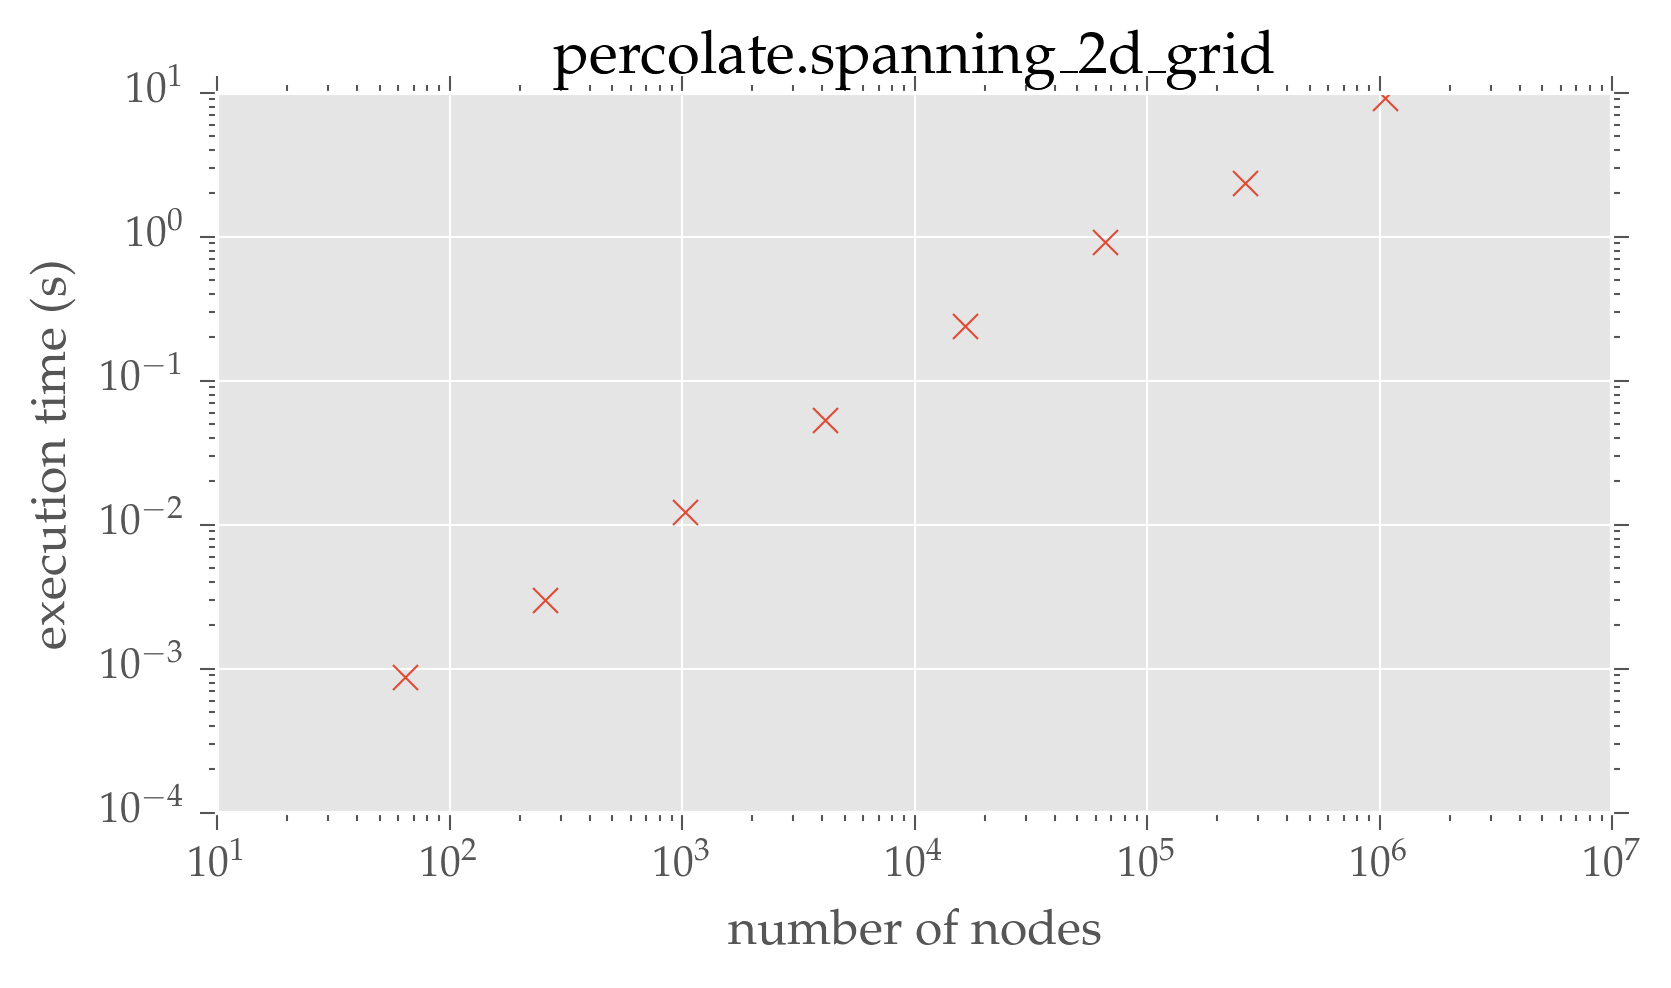

In [40]:
plt.loglog(dimensions ** 2, graph_times, 'x')
plt.xlabel(r'number of nodes')
plt.ylabel(r'execution time (s)')
plt.title(r'percolate.spanning\_2d\_grid')
plt.show()

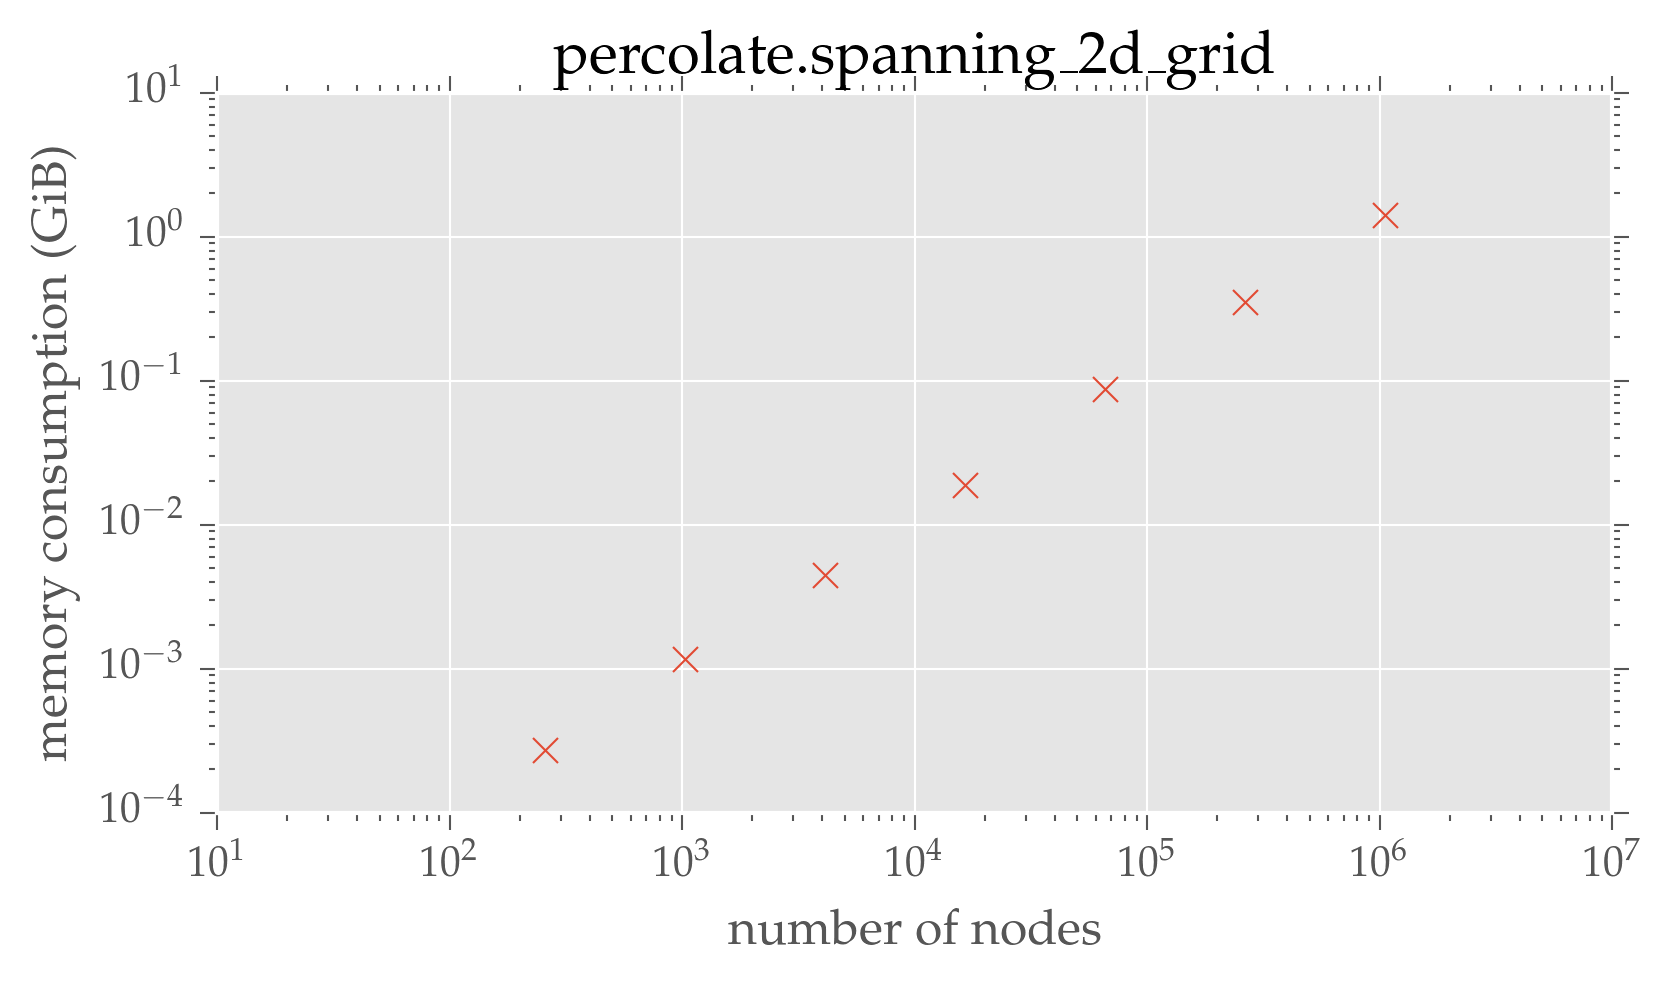

In [39]:
plt.loglog(dimensions ** 2, graph_mem / 2 ** 10, 'x')
plt.xlabel(r'number of nodes')
plt.ylabel('memory consumption (GiB)')
plt.title('percolate.spanning\_2d\_grid')
plt.show()

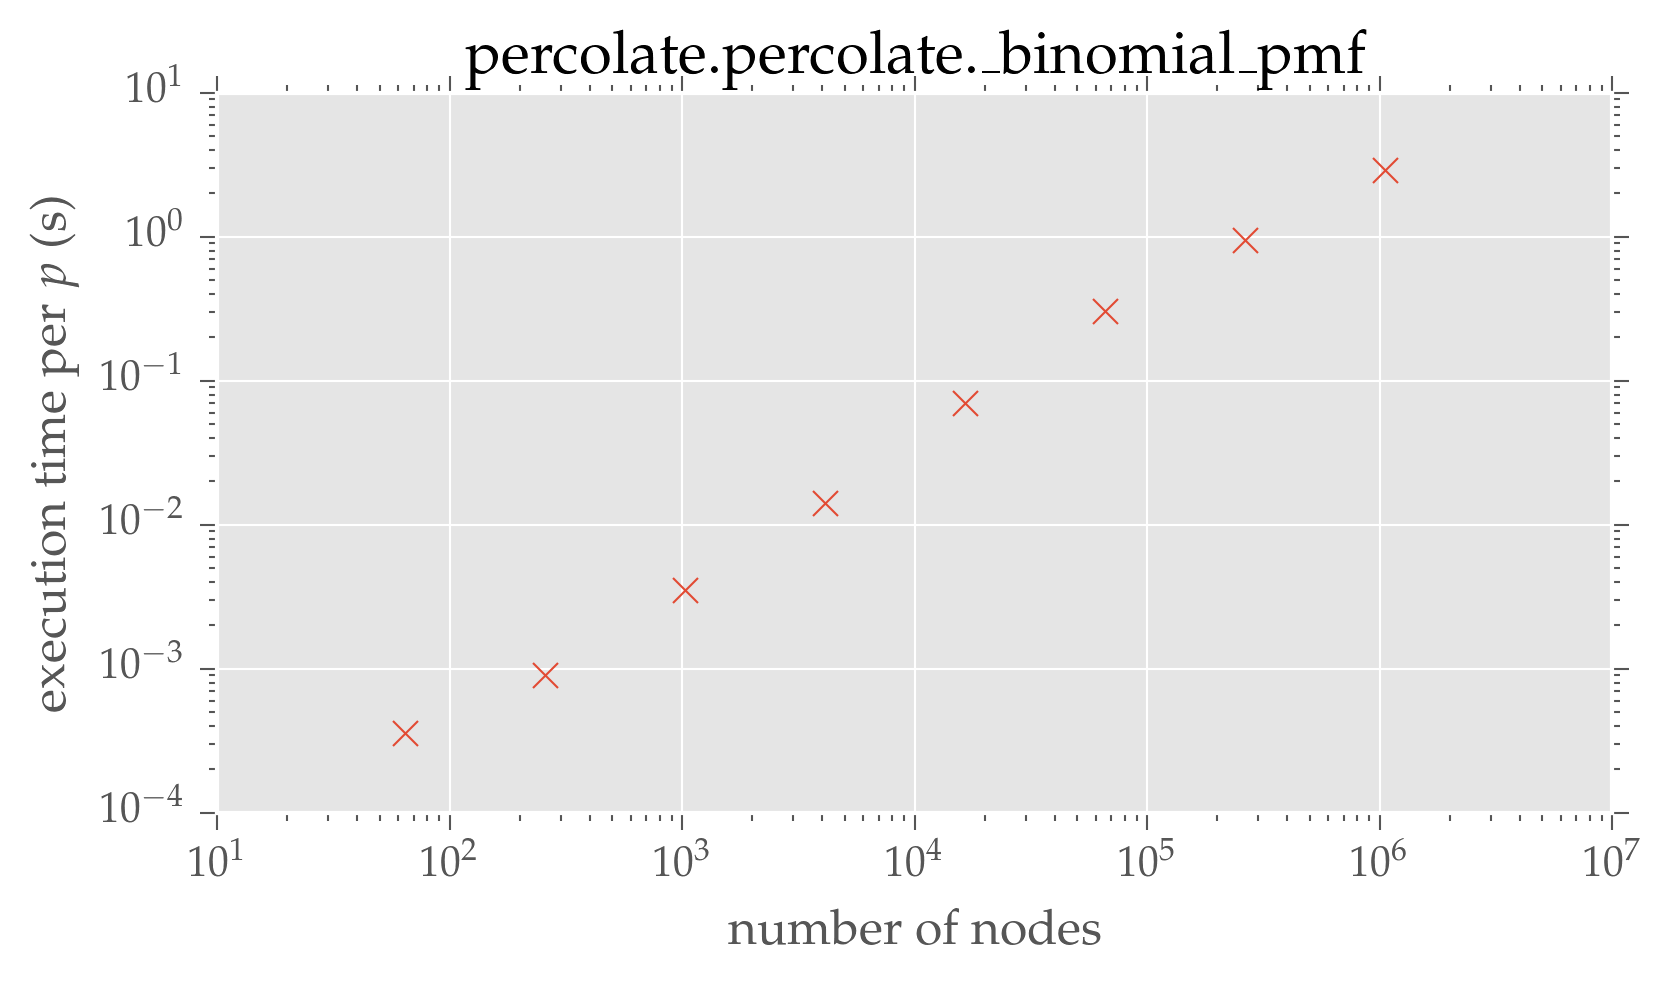

In [32]:
plt.loglog(dimensions ** 2, convolution_times, 'x')
plt.xlabel(r'number of nodes')
plt.ylabel(r'execution time per $p$ (s)')
plt.title('percolate.percolate.\_binomial\_pmf')
plt.show()

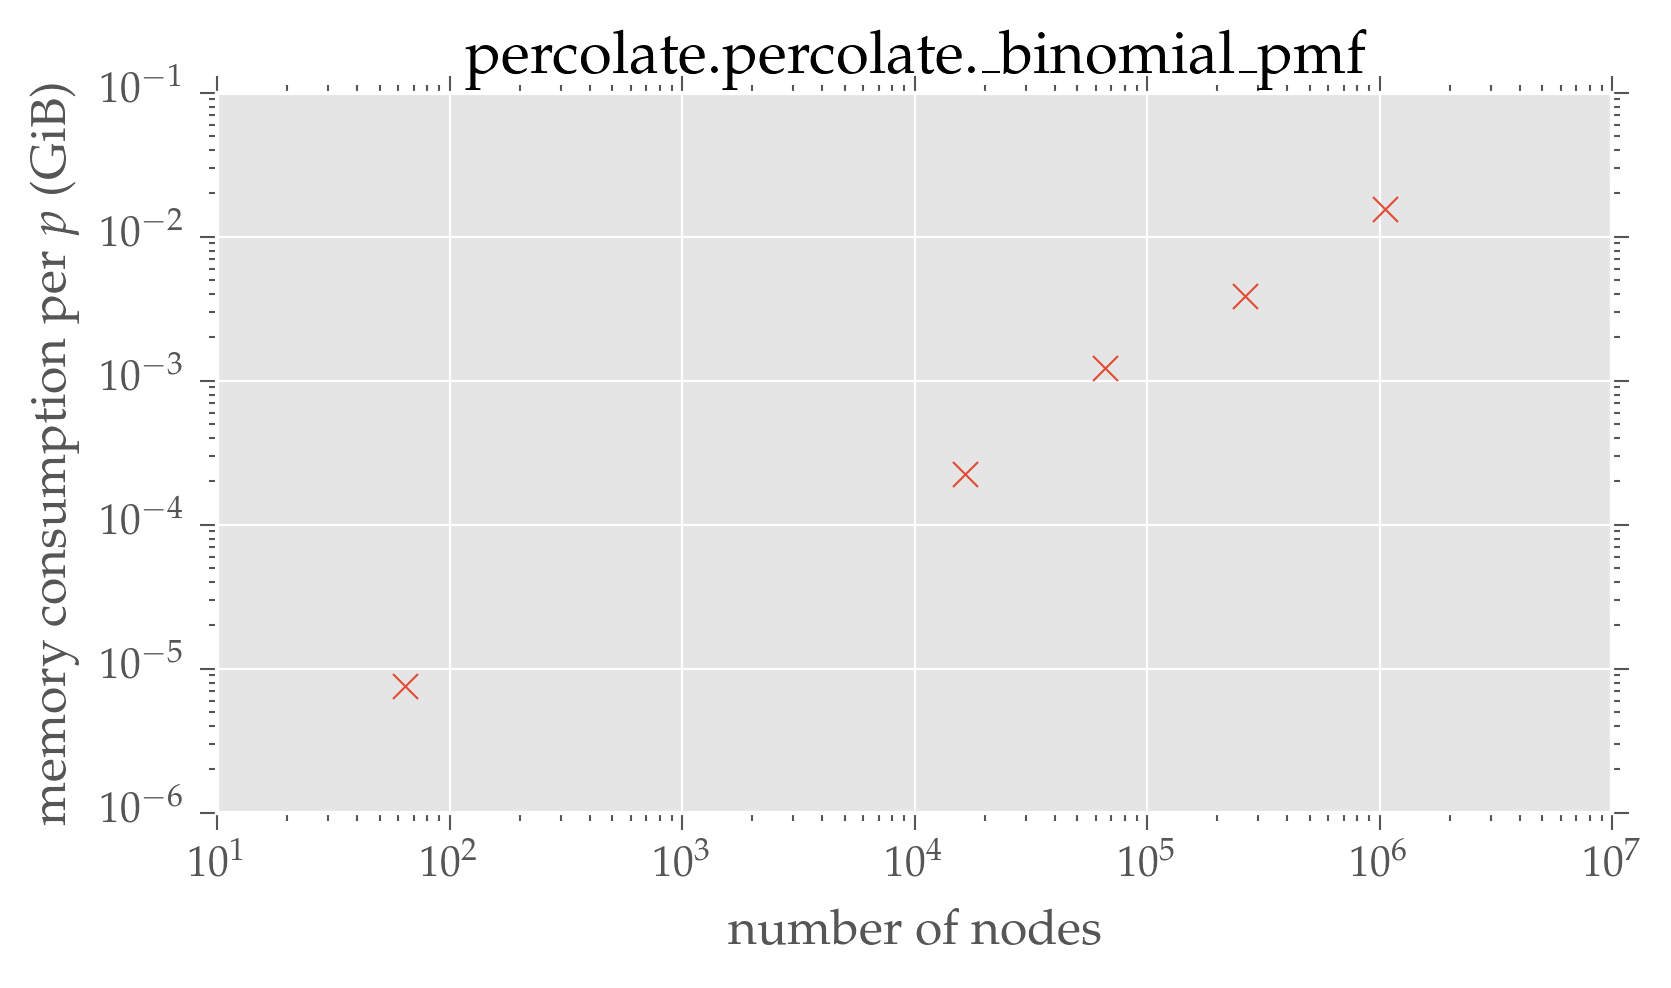

In [33]:
plt.loglog(dimensions ** 2, convolution_mem / 2 ** 10, 'x')
plt.xlabel(r'number of nodes')
plt.ylabel(r'memory consumption per $p$ (GiB)')
plt.title('percolate.percolate.\_binomial\_pmf')
plt.show()

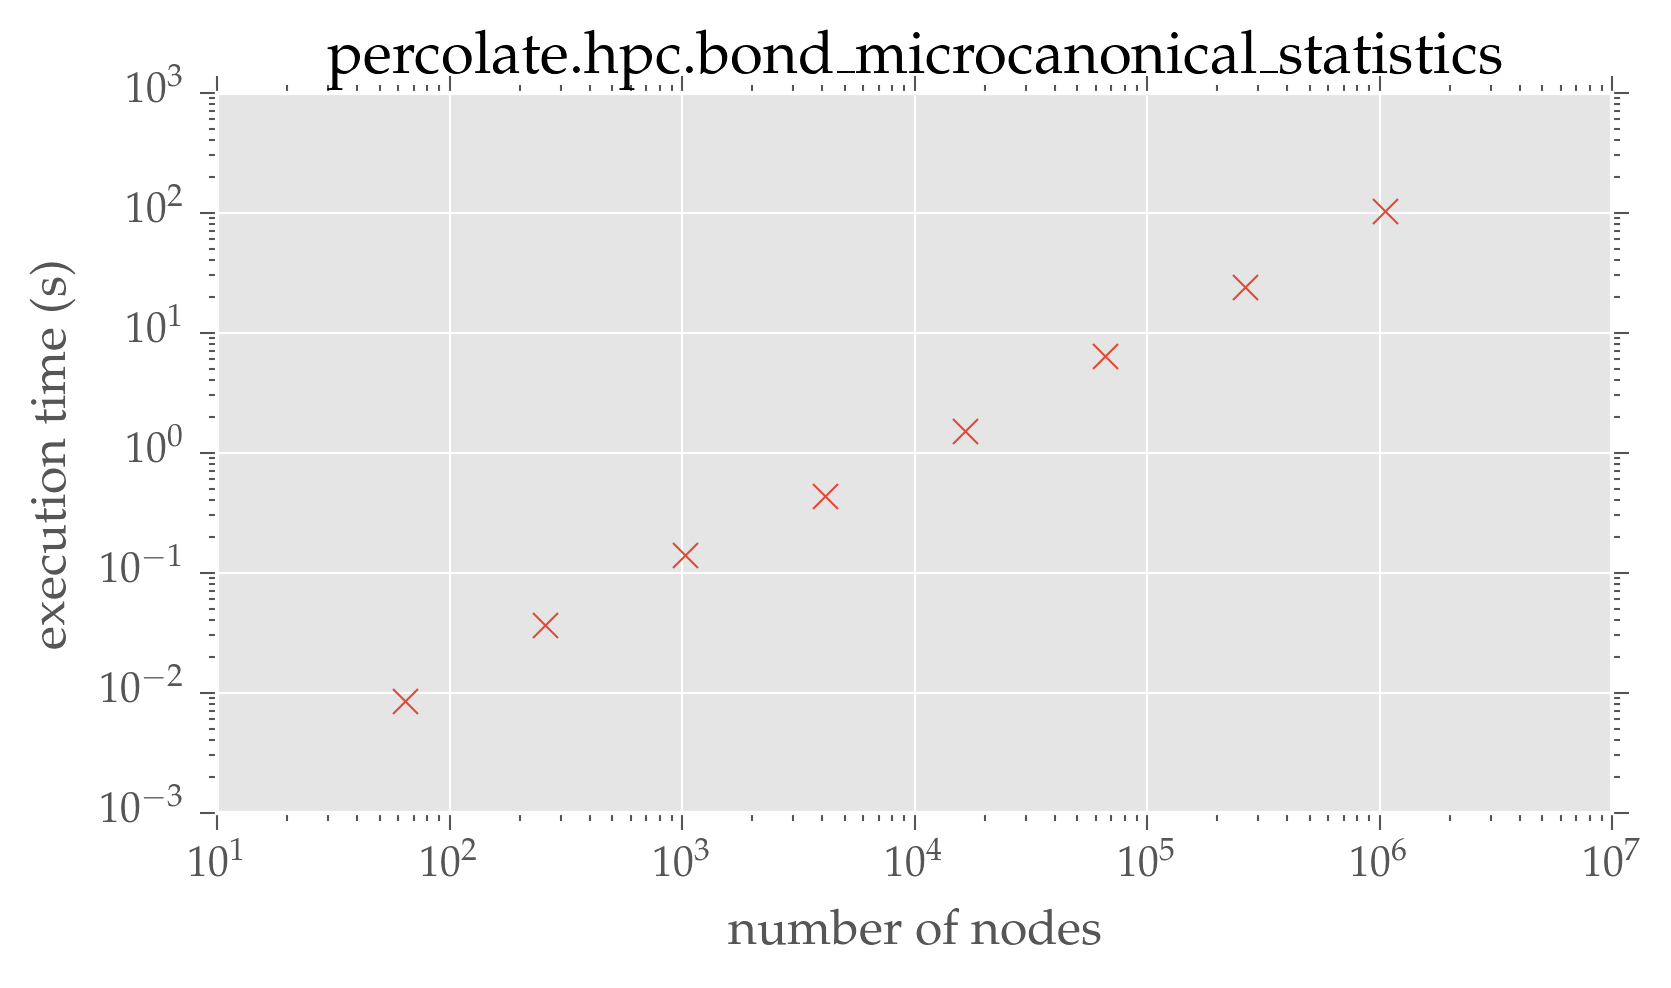

In [34]:
plt.loglog(dimensions ** 2, run_times, 'x')
plt.xlabel(r'number of nodes')
plt.ylabel(r'execution time (s)')
plt.title('percolate.hpc.bond\_microcanonical\_statistics')
plt.show()

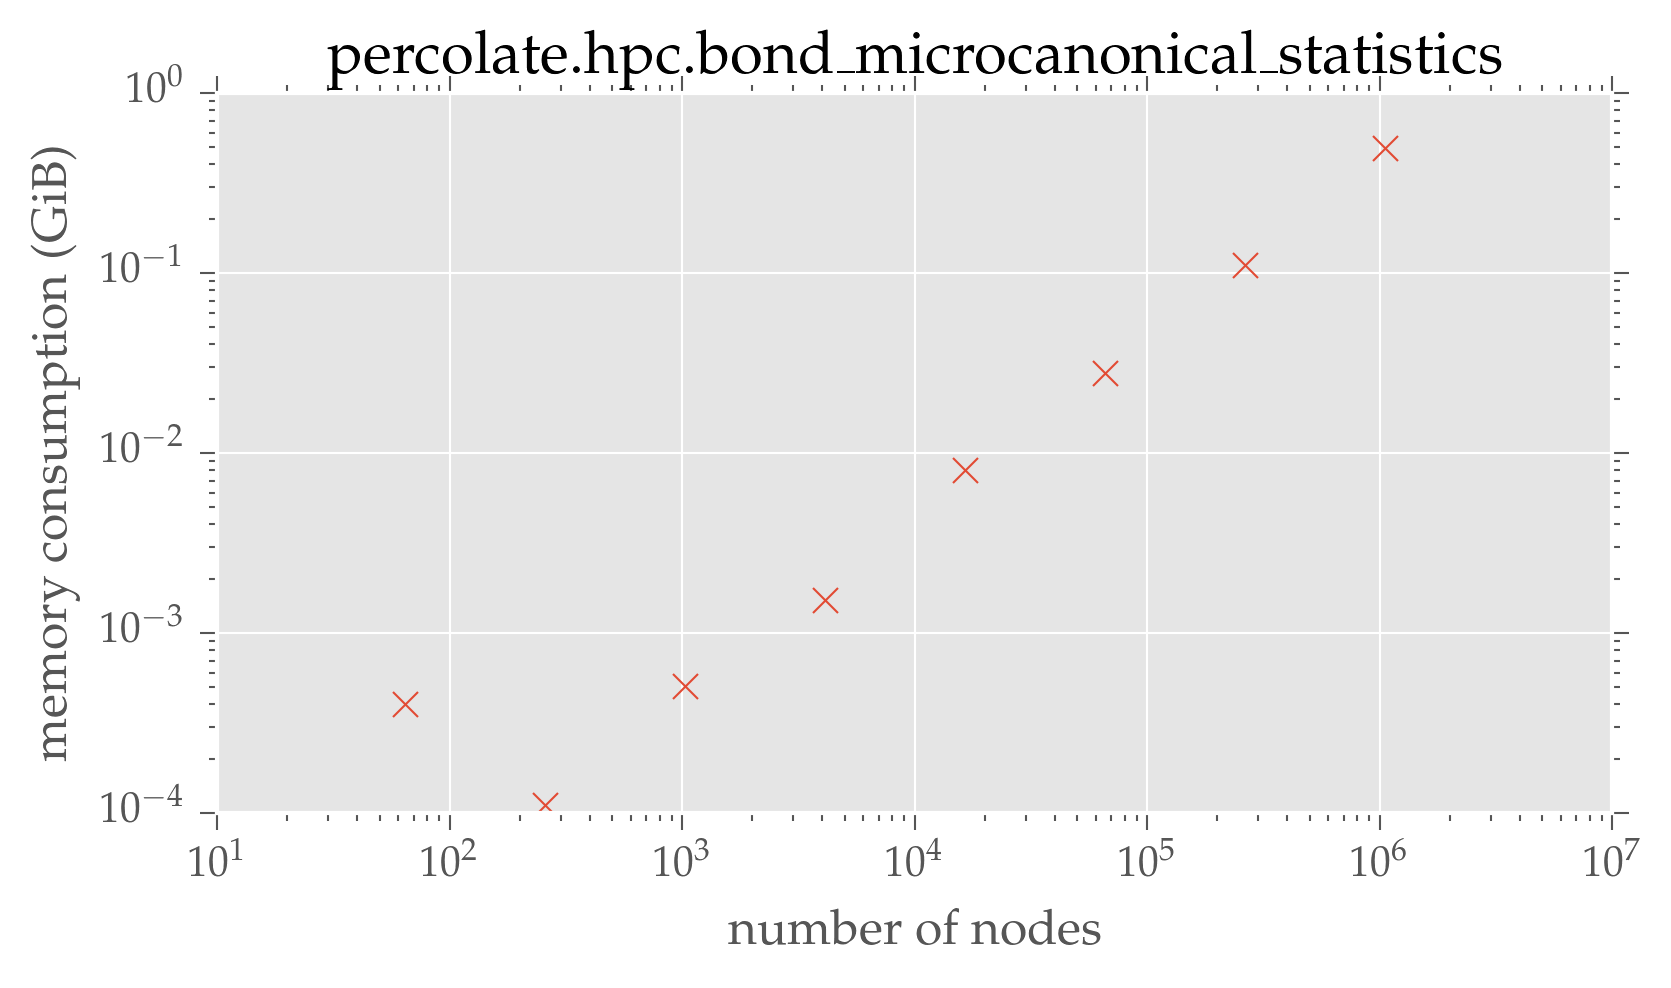

In [35]:
plt.loglog(dimensions ** 2, run_mem / 2 ** 10, 'x')
plt.xlabel(r'number of nodes')
plt.ylabel(r'memory consumption (GiB)')
plt.title('percolate.hpc.bond\_microcanonical\_statistics')
plt.show()